In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt

from src.data import read_data

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
DATA = Path().cwd().parent / "data"

In [4]:
df = read_data(DATA / "train.csv")
df.head()

2023-11-26 15:25:00,330 - logger - INFO - Leyendo datos de /home/jjmov99/universidad/proyecto_despliegue_de_modelos/data/train.csv ...


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Outliers

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from collections import Counter
from category_encoders import TargetEncoder, CountEncoder

In [6]:
encoder = TargetEncoder()
imputer = KNNImputer(n_neighbors=10, weights='distance')
outlier_detector = IsolationForest(n_estimators=100, n_jobs=-1, random_state=1399, verbose=1)
featurizer = make_pipeline(encoder, imputer, outlier_detector)

In [7]:
tmp_x = df.drop(columns=["SalePrice"], axis=1).copy()

In [8]:
outlier = featurizer.fit_predict(tmp_x, df.SalePrice)
Counter(outlier)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 out of  24 | elapsed:    0.1s remaining:    1.6s
[Parallel(n_jobs=24)]: Done  24 out of  24 | elapsed:    0.2s finished


Counter({1: 1362, -1: 98})

In [9]:
df['is_outlier'] = outlier
del tmp_x

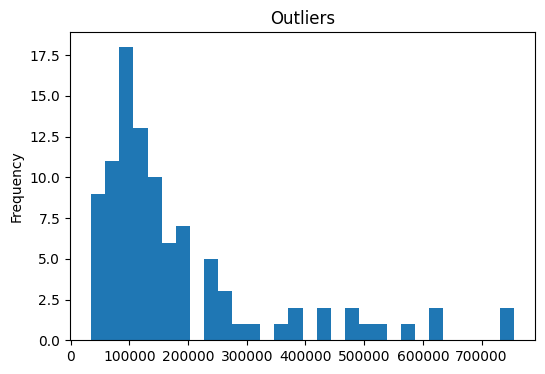

In [10]:
plt.figure(figsize=(6, 4))
df[df['is_outlier'] == -1]['SalePrice'].plot(kind='hist', title='Outliers', bins=30)
plt.show()

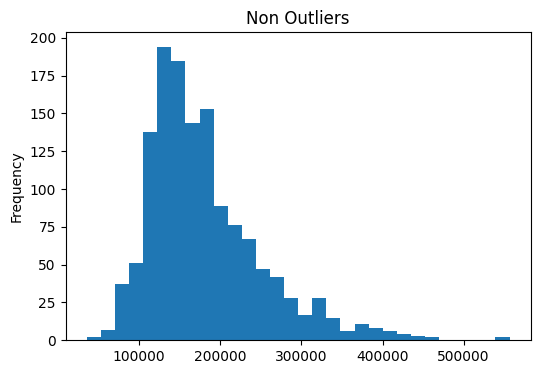

In [11]:
plt.figure(figsize=(6, 4))
df[df['is_outlier'] == 1]['SalePrice'].plot(kind='hist', title='Non Outliers', bins=30)
plt.show()

In [48]:
df[df['is_outlier'] == 1].drop('is_outlier', axis=1).to_csv(DATA / "train_wo_outliers.csv", index=False)

#### Preprocess

In [12]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

In [40]:
feature_selector = SelectFromModel(XGBRegressor(n_estimators=500, tree_method='hist', device='cuda', random_state=1399))
pipe = make_pipeline(TargetEncoder(), imputer, feature_selector)

In [41]:
X, y = df[df['is_outlier'] == 1].drop(columns=["SalePrice"]), np.log(df[df['is_outlier'] == 1]['SalePrice'])
X = pipe.fit_transform(X, y)

2023/11/26 15:40:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '144f2daf52f841809abff7e663d881de', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2023/11/26 15:40:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jjmov99/universidad/proyecto_despliegue_de_modelos/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2023/11/26 15:40:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/j

In [42]:
test = pd.DataFrame(X, columns=pipe.get_feature_names_out())
test.head()

,Neighborhood,BldgType,OverallQual,OverallCond,RoofMatl,BsmtQual,BsmtFinSF1,TotalBsmtSF,GrLivArea,KitchenQual,GarageType,GarageCars
0,12.163641,12.056065,7.0,5.0,12.032978,12.183617,706.0,856.0,1710.0,12.215930,12.149394,2.0
1,12.104821,12.056065,6.0,8.0,12.032978,12.183617,978.0,1262.0,1262.0,11.826008,12.149394,2.0
2,12.163641,12.056065,7.0,5.0,12.032978,12.183617,486.0,920.0,1786.0,12.215930,12.149394,2.0
3,12.169387,12.056065,7.0,5.0,12.032978,11.823752,216.0,756.0,1717.0,12.215930,11.769633,3.0
4,12.531592,12.056065,8.0,5.0,12.032978,12.183617,655.0,1145.0,2198.0,12.215930,12.149394,3.0


In [22]:
dtrain = xgb.DMatrix(X, label=y, feature_names=pipe.get_feature_names_out().tolist())

In [23]:
params = {
    'device': 'cuda',
    'eta': 0.1,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=10,
    seed=1399,
    shuffle=True,
    early_stopping_rounds=5,
    verbose_eval=10,
    show_stdv=False,
)

[0]	train-rmse:0.33479	test-rmse:0.33589
[10]	train-rmse:0.15742	test-rmse:0.17922
[20]	train-rmse:0.09693	test-rmse:0.13702
[30]	train-rmse:0.07586	test-rmse:0.12696
[40]	train-rmse:0.06667	test-rmse:0.12430
[50]	train-rmse:0.06155	test-rmse:0.12333
[60]	train-rmse:0.05808	test-rmse:0.12312
[63]	train-rmse:0.05727	test-rmse:0.12312


#### Experimento

In [24]:
import mlflow
import mlflow.xgboost
from sklearn.model_selection import train_test_split

In [25]:
TRACKING_SERVER_HOST = "http://100.26.39.17:5000"
mlflow.set_tracking_uri(TRACKING_SERVER_HOST)
mlflow.set_experiment("prediccion-precios-casas")
mlflow.xgboost.autolog(importance_types=["gain"], model_format="json")

In [49]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.early_stop import no_progress_loss

In [52]:
fixed_params = {
    'seed': 1399,
    'tree_method': 'hist',
    'device': 'cuda',
    'grow_policy': 'lossguide',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

cv_params = {
    'dtrain': dtrain,
    'num_boost_round': 1000,
    'nfold': 10,
    'early_stopping_rounds': 5,
    'verbose_eval': 10,
    'seed': 1399,
    'show_stdv': False
}

In [61]:
colsample_bytree = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
reg_lambda = [1e-5, 1e-2, 0.1, 1, 100]

space = {
    'max_depth': hp.quniform('max_depth', 1, 100, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'gamma': hp.loguniform('gamma', -5, 1),
    'colsample_bytree': hp.choice('colsample_bytree', colsample_bytree),
    'subsample': hp.choice('subsample', subsample),
    'reg_alpha': hp.choice('reg_alpha', reg_alpha),
    'reg_lambda': hp.choice('reg_lambda', reg_lambda),
}

In [62]:
def objective(space):

    fixed_params['learning_rate'] = space['learning_rate']
    fixed_params['max_depth'] = int(space['max_depth'])
    fixed_params['min_child_weight'] = space['min_child_weight']
    fixed_params['gamma'] = space['gamma']
    fixed_params['colsample_bytree'] = space['colsample_bytree']
    fixed_params['subsample'] = space['subsample']
    fixed_params['reg_alpha'] = space['reg_alpha']
    fixed_params['reg_lambda'] = space['reg_lambda']

    print(fixed_params)
    
    xgb_cv = xgb.cv(params=fixed_params, **cv_params)

    best_iter = np.argmin(xgb_cv['test-rmse-mean'])
    logloss = xgb_cv['test-rmse-mean'][best_iter]
    
    return {'loss': logloss, 'status': STATUS_OK}

In [63]:
trials = Trials()
best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    early_stop_fn=no_progress_loss(iteration_stop_count=10)
)

{'seed': 1399, 'tree_method': 'hist', 'device': 'cuda', 'grow_policy': 'lossguide', 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'learning_rate': 0.38176935856071376, 'max_depth': 49, 'min_child_weight': 5.193117232497799, 'gamma': 1.1474846793279023, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 1e-05, 'reg_lambda': 1}
[0]	train-rmse:0.28796	test-rmse:0.29028              
[10]	train-rmse:0.13999	test-rmse:0.14669             
[14]	train-rmse:0.13945	test-rmse:0.14671             
{'seed': 1399, 'tree_method': 'hist', 'device': 'cuda', 'grow_policy': 'lossguide', 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'learning_rate': 0.5352195694534931, 'max_depth': 33, 'min_child_weight': 10.653560067932906, 'gamma': 0.012253852411583856, 'colsample_bytree': 0.4, 'subsample': 0.7, 'reg_alpha': 1, 'reg_lambda': 100}
[0]	train-rmse:0.30599	test-rmse:0.30614                                        
[10]	train-rmse:0.14469	test-rmse:0.15263                           

In [64]:
best_hyperparams

{'colsample_bytree': 3,
 'gamma': 0.018107780248991318,
 'learning_rate': 0.056536933784715235,
 'max_depth': 70.0,
 'min_child_weight': 1.5481359796122345,
 'reg_alpha': 0,
 'reg_lambda': 3,
 'subsample': 0}

In [65]:
print(colsample_bytree[3])
print(subsample[0])
print(reg_alpha[0])
print(reg_lambda[3])

0.6
0.6
1e-05
1


In [69]:
0.00001 == 1e-05

True

In [67]:
1e-05

1e-05